## Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # For ACF & PACF
import tensorflow as tf
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

## Data Preprocessing

In [3]:
# Load Bitcoin historical data
crypto_df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\coin_Bitcoin.csv")

# Load Macroeconomic Indicators data
macro_df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\economic_indicators.csv")

# Convert Date columns to datetime format
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'])
macro_df['Date'] = pd.to_datetime(macro_df['Date'])

# Drop 'SNo' column (it does not add analytical value)
crypto_df.drop(columns=['SNo'], inplace=True, errors='ignore')

# Preprocessing

# Resample Cryptocurrency Data to Monthly Frequency

# Select only numeric columns for resampling
numeric_columns = crypto_df.select_dtypes(include=['number']).columns

# Resample the dataset to monthly frequency (ME = Month End)
crypto_df = crypto_df.set_index('Date').resample('ME')[numeric_columns].mean().reset_index()

# Merge Cryptocurrency Data with Macroeconomic Data

# Merge datasets on 'Date' using a left join
merged_df = pd.merge(crypto_df, macro_df, on='Date', how='left')

# Handle missing values using forward fill (ffill ensures consistent data)
merged_df.ffill(inplace=True)

# Select Key Countries for Analysis

# Define selected countries for a balanced, in-depth analysis
selected_countries = ['USA', 'China', 'Germany', 'UK', 'India']

# Drop 'Unemployment Rate (%)' as it is less relevant to Bitcoin price movements
merged_df.drop(columns=['Unemployment Rate (%)'], inplace=True, errors='ignore')

# Filter dataset for the selected countries only
merged_df = merged_df[merged_df['Country'].isin(selected_countries)]

# Save merged dataset BEFORE feature engineering
merged_df.to_csv(r"C:\Users\vaish\OneDrive\UH\Project\merged_crypto_macro_data.csv", index=False)
print("Merged dataset saved successfully!")

Merged dataset saved successfully!


## Feature Engineering

Feature engineering completed! Processed dataset saved successfully!


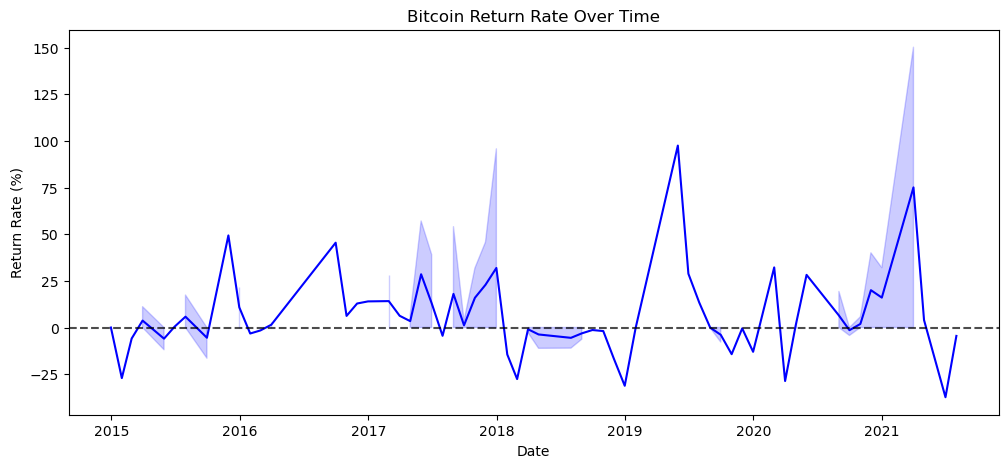

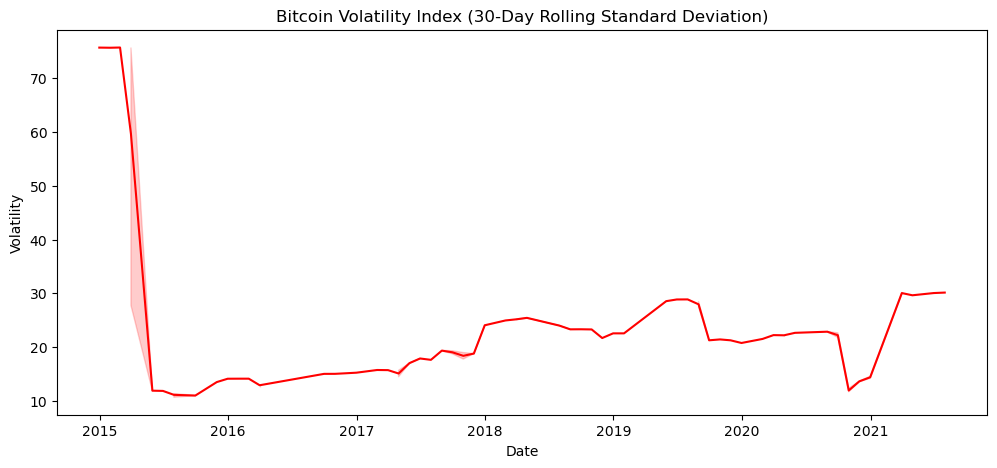

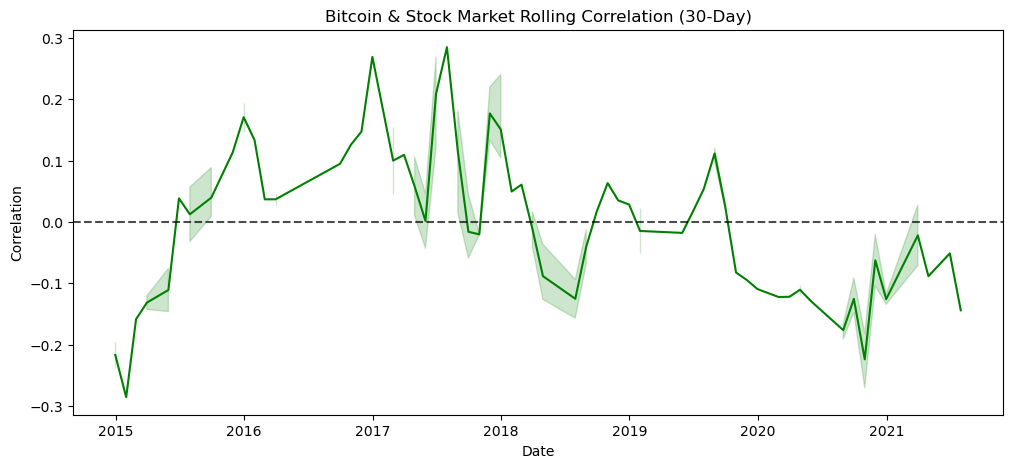

In [5]:
# 1. Load Merged Dataset & Convert Date Column

# Load the merged dataset (before feature engineering)
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\merged_crypto_macro_data.csv")

# Convert 'Date' column to datetime and set as index for visualization
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 2. Feature Engineering

# Bitcoin Return Rate (Daily Percentage Change)
df['Bitcoin_Return_Rate'] = df['Close'].pct_change() * 100

# Volatility Index (Rolling Standard Deviation of Returns over 30 days)
df['Volatility_Index'] = df['Bitcoin_Return_Rate'].rolling(window=30).std()

# Rolling Correlation (Bitcoin vs Stock Market Index over 30 days)
if 'Stock Index Value' in df.columns:
    df['Rolling_Correlation'] = df['Close'].rolling(window=30).corr(df['Stock Index Value'])
else:
    df['Rolling_Correlation'] = np.nan  # Assign NaN if Stock Index column is missing

# Drop NaN values generated by rolling calculations (first 30 rows)
df.dropna(inplace=True)

# Save the feature-engineered dataset
df.to_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv", index=True)

print("Feature engineering completed! Processed dataset saved successfully!")

# 3. Visualization of Engineered Features

# Bitcoin Return Rate Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['Bitcoin_Return_Rate'], color='blue')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title("Bitcoin Return Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Return Rate (%)")
plt.show()

# Bitcoin Volatility Index (30-Day Rolling Standard Deviation)
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['Volatility_Index'], color='red')
plt.title("Bitcoin Volatility Index (30-Day Rolling Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

# Bitcoin & Stock Market Rolling Correlation (30-Day)
if 'Stock Index Value' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=df.index, y=df['Rolling_Correlation'], color='green')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.title("Bitcoin & Stock Market Rolling Correlation (30-Day)")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.show()

## Support Vector Machine (SVM) Model

Fitting 5 folds for each of 80 candidates, totalling 400 fits

SVM Model Performance:
Root Mean Squared Error (RMSE): 21263.61
Mean Absolute Error (MAE): 14992.98
Mean Absolute Percentage Error (MAPE): 64.28%
SVM Directional Accuracy: 17.39%


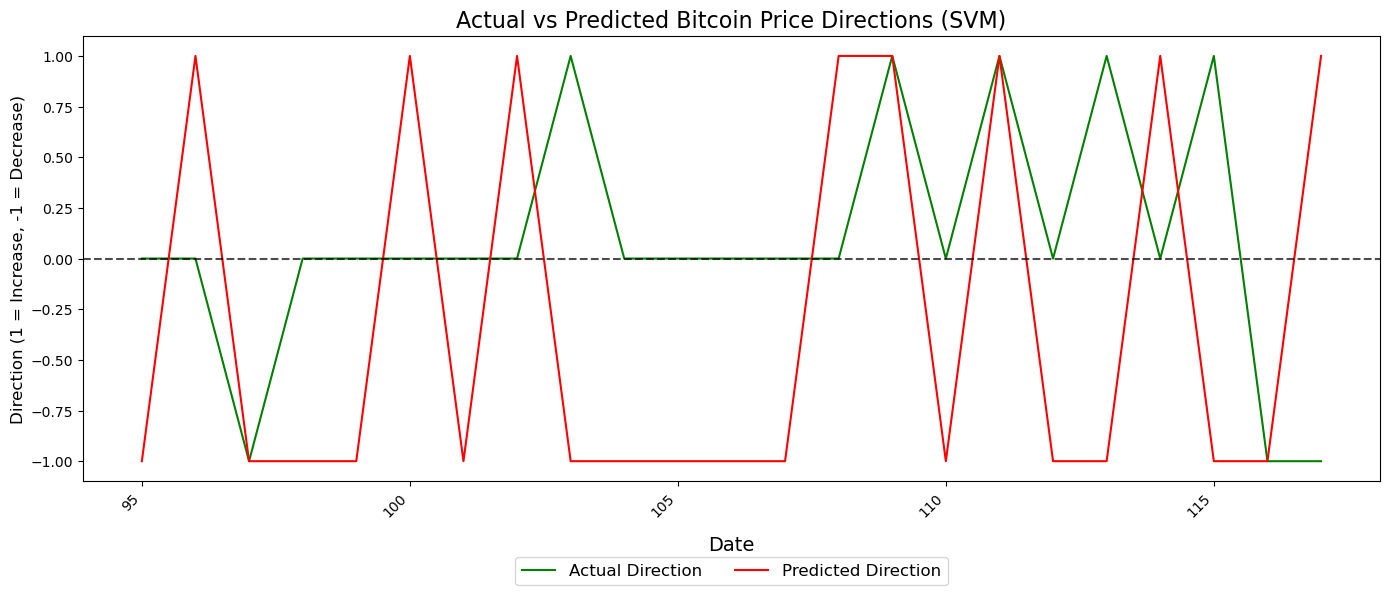

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load Processed Data & Prepare Features
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv")

# Define features & target
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation']
target = 'Close'  # Bitcoin closing price

X = df[features]  # Independent variables
y = df[target]  # Target variable

# Split dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize features (SVM is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Hyperparameter Tuning for SVM
param_grid = {
    'C': [10, 50, 100, 500, 1000],   # Regularization parameter
    'gamma': ['scale', 0.01, 0.1, 1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.5, 1]  # Margin of tolerance
}

svm_model = SVR(kernel='rbf')

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters found
best_params = grid_search.best_params_

# Train SVM Model with Best Parameters
svm_best = SVR(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], epsilon=best_params['epsilon'])
svm_best.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_svm = svm_best.predict(X_test_scaled)

# 3. Evaluate Model Performance
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mape_svm = np.mean(np.abs((y_test - y_pred_svm) / y_test)) * 100

# Print evaluation metrics
print("\nSVM Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_svm:.2f}")
print(f"Mean Absolute Error (MAE): {mae_svm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svm:.2f}%")

# 4. Compute Actual & Predicted Price Directions
actual_direction_svm = np.sign(np.diff(y_test))  # 1 if price increased, -1 if decreased
predicted_direction_svm = np.sign(np.diff(y_pred_svm))

# Ensure the index aligns with the diff result
aligned_index = y_test.index[1:]  # Skip the first element

# Compute Directional Accuracy AFTER defining actual_direction_svm & predicted_direction_svm
directional_accuracy_svm = np.mean(actual_direction_svm == predicted_direction_svm) * 100
print(f"SVM Directional Accuracy: {directional_accuracy_svm:.2f}%")

# 5. Plot Actual vs Predicted Price Directions
plt.figure(figsize=(14, 6))

# Plot actual price directions
sns.lineplot(x=aligned_index, y=actual_direction_svm, label='Actual Direction', color='green')

# Plot predicted price directions
sns.lineplot(x=aligned_index, y=predicted_direction_svm, label='Predicted Direction', color='red')

# Customizing the plot
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)  
plt.title("Actual vs Predicted Bitcoin Price Directions (SVM)", fontsize=16)
plt.xlabel("Date", fontsize=14, labelpad=11)  # Increase label size & padding
plt.ylabel("Direction (1 = Increase, -1 = Decrease)", fontsize=12)

# Move legend outside to avoid overlap
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")  

# Add more space at the bottom for x-axis label
plt.subplots_adjust(bottom=0.2)  

# Automatically adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Long Short-Term Memory (LSTM) Model

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 0.0605 - val_loss: 0.1113
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0217 - val_loss: 0.1940
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0142 - val_loss: 0.1577
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0086 - val_loss: 0.1184
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0077 - val_loss: 0.1319
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0050 - val_loss: 0.1507
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0076 - val_loss: 0.1307
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0036 - val_loss: 0.1203
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0035 - val_loss: 0.1188
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0032 - val_loss: 0.1283
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0033 - val_loss: 0.1226
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0030 - val_loss: 0.1111


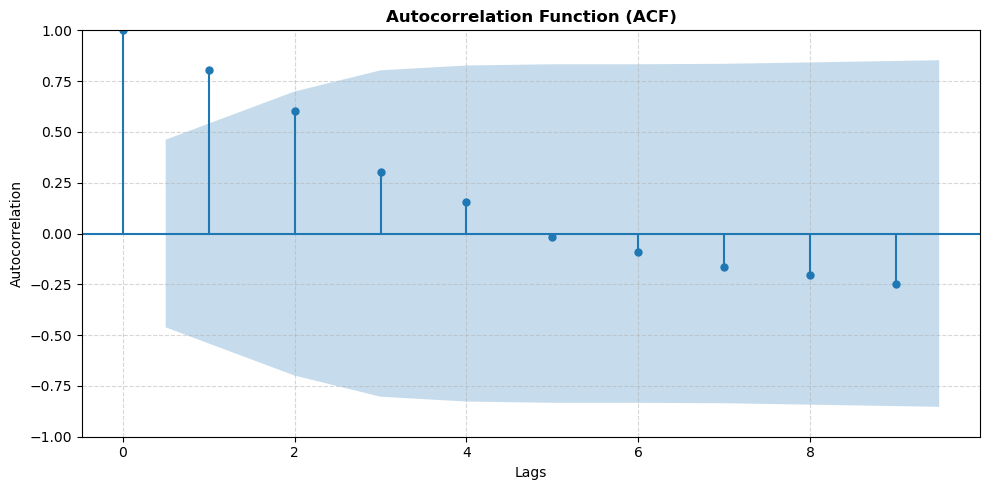

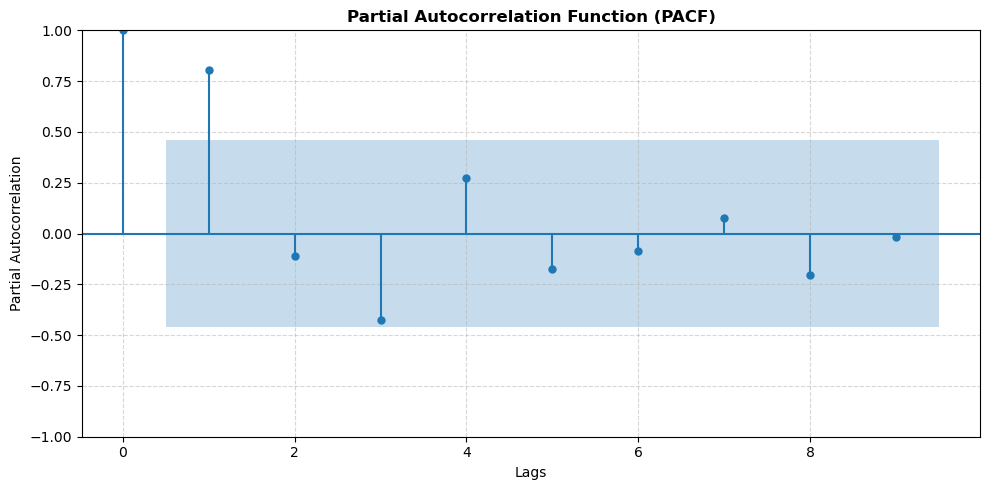

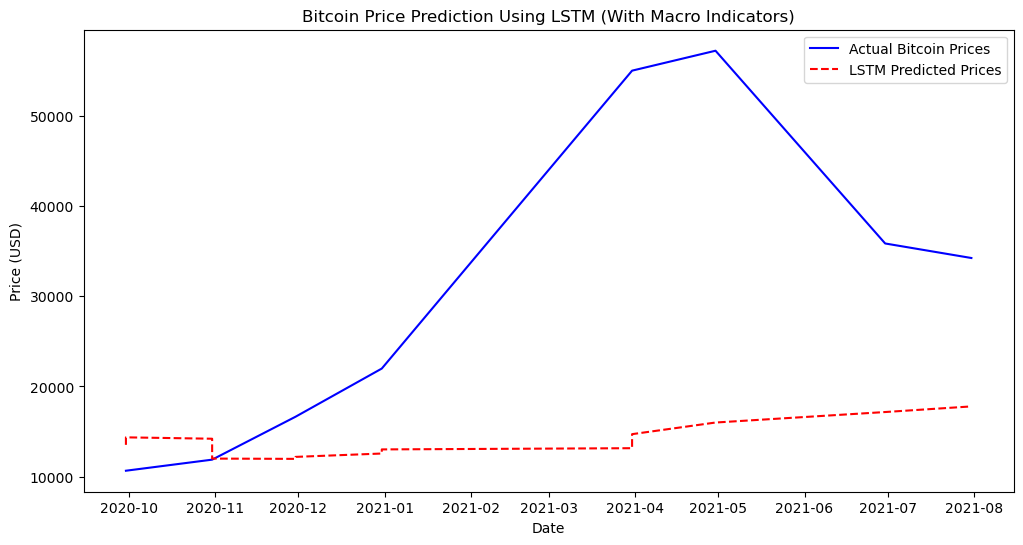

In [15]:
# 1. Load Processed Data & Prepare for LSTM

# Load dataset
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define features & target
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation', 'Close']  
target = 'Close'  # Bitcoin closing price

X = df[features].values  # Independent variables (including macro indicators)
y = df[target].values  # Target variable (Bitcoin price)

# Normalize features using MinMaxScaler (LSTM prefers scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Normalize target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

# 2. Convert Data to Time-Series Format for LSTM

def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])  # Now includes macro indicators + price
        ys.append(y[i+time_steps])  # Future price prediction
    return np.array(Xs), np.array(ys)

# Use past 30 days to predict the next day
time_steps = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split into training (80%) and testing (20%)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 3. Build & Train LSTM Model with Macro Indicators

# Define LSTM architecture with macroeconomic indicators
model = Sequential([
    Input(shape=(time_steps, X.shape[1])),  # Explicit input layer
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# 4. Make Predictions & Evaluate Model

# Ensure consistent input shape before prediction
X_test_fixed = np.array(X_test, dtype=np.float32)

# Use tf.function to prevent retracing
@tf.function(reduce_retracing=True)
def make_prediction(model, data):
    return model(data)

# Make predictions
y_pred_scaled = make_prediction(model, X_test_fixed)
# Convert predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# Calculate RMSE, MAE, and MAPE
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae_lstm = mean_absolute_error(y_test_actual, y_pred)
mape_lstm = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

# Print results
print("LSTM Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}%")

# 5. Compute Directional Accuracy (%)

# Compute actual & predicted price directions
actual_direction_lstm = np.sign(np.diff(y_test_actual.flatten()))  # 1 if price increased, -1 if decreased
predicted_direction_lstm = np.sign(np.diff(y_pred.flatten()))

# Compute accuracy
directional_accuracy_lstm = np.mean(actual_direction_lstm == predicted_direction_lstm) * 100

# Print Directional Accuracy
print(f"LSTM Directional Accuracy: {directional_accuracy_lstm:.2f}%")

# 6. Compute Autocorrelation Function (ACF) & Partial ACF (PACF)

# Determine safe lags for ACF/PACF (ensures valid range)
max_lags = min(30, len(y_test_actual) - 1, len(y_test_actual) // 2)  # Safe limit for PACF

# Compute & plot ACF only if we have enough data points
if max_lags > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    sm.graphics.tsa.plot_acf(y_test_actual.flatten(), lags=max_lags, ax=ax)  # Pass ax to avoid empty figure
    ax.set_title(f"Autocorrelation Function (ACF)", fontsize=12, fontweight="bold")
    ax.set_xlabel("Lags", fontsize=10)
    ax.set_ylabel("Autocorrelation", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()  # Adjust layout to prevent cutoff
    plt.show()

    # Compute & plot PACF only if it's within valid range
    if max_lags >= 1:
        fig, ax = plt.subplots(figsize=(10, 5))
        sm.graphics.tsa.plot_pacf(y_test_actual.flatten(), lags=max_lags, ax=ax)  # Pass ax
        ax.set_title(f"Partial Autocorrelation Function (PACF)", fontsize=12, fontweight="bold")
        ax.set_xlabel("Lags", fontsize=10)
        ax.set_ylabel("Partial Autocorrelation", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for PACF computation. Skipping PACF plot.")
else:
    print("Not enough data for ACF/PACF computation. Skipping both plots.")

# 7. Visualize Predictions vs Actual Prices

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Bitcoin Prices", color='blue')
plt.plot(df.index[-len(y_pred):], y_pred, label="LSTM Predicted Prices", color='red', linestyle='dashed')
plt.title("Bitcoin Price Prediction Using LSTM (With Macro Indicators)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

## eXtreme Gradient Boosting (XGBoost) Model

XGBoost Model Performance:
Root Mean Squared Error (RMSE): 20688.08
Mean Absolute Error (MAE): 15166.30
Mean Absolute Percentage Error (MAPE): 67.34%
XGBoost Directional Accuracy: 26.09%


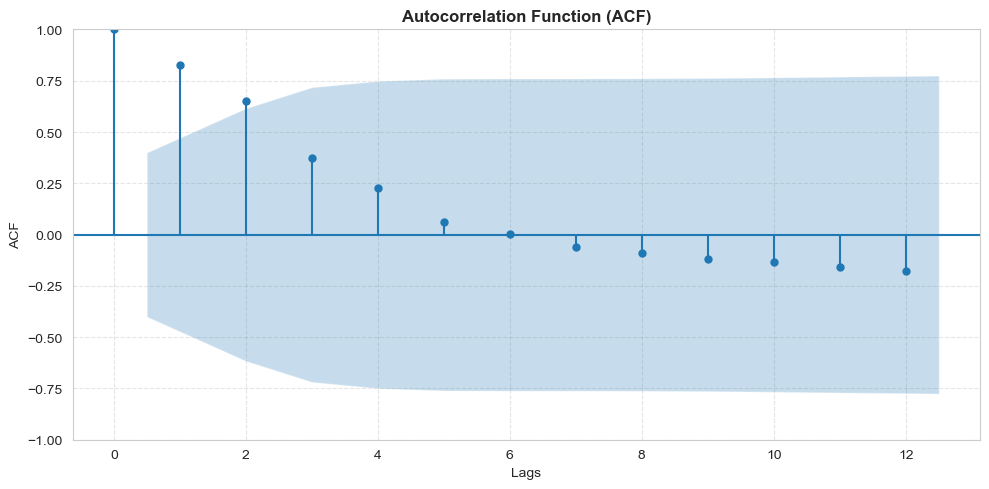

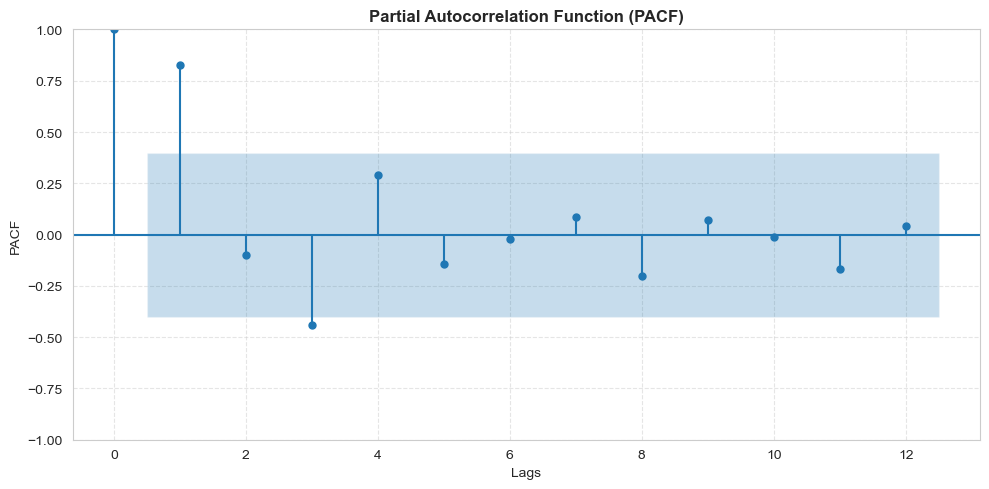

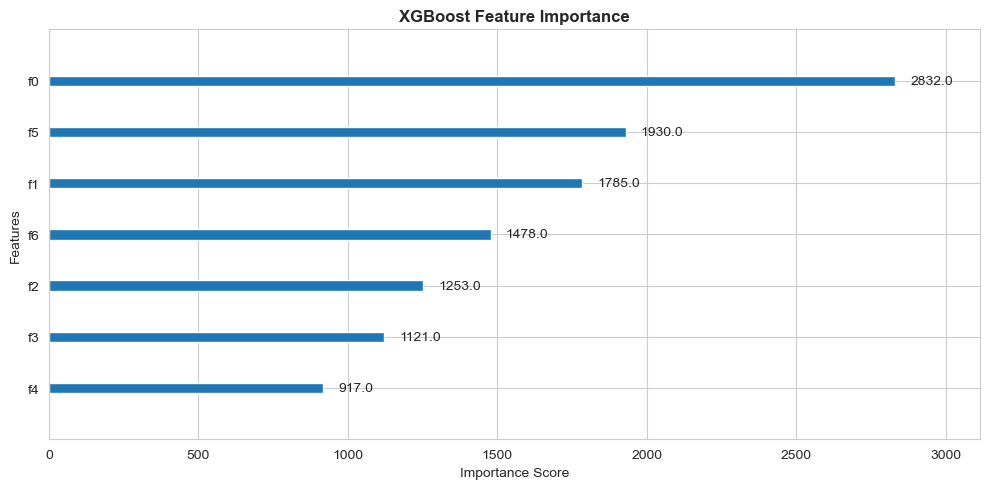

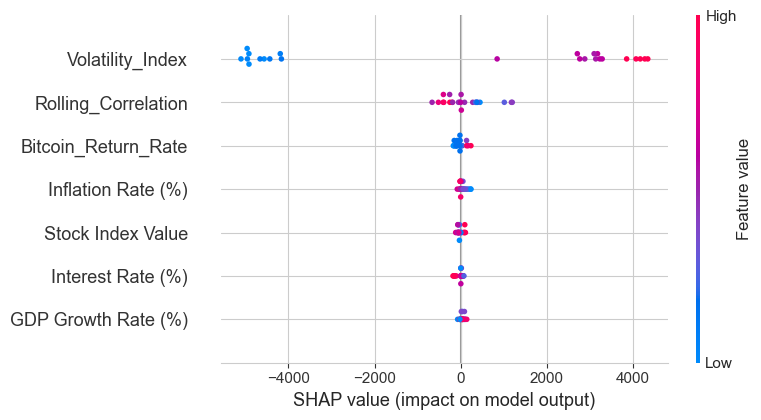

In [21]:
# 1. Load Processed Data & Prepare Features

# Load the processed dataset
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv")

# Define features (independent variables) and target (Bitcoin Closing Price)
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation']
target = 'Close'  # Bitcoin closing price

X = df[features]
y = df[target]

# Split dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize features (XGBoost is tree-based but normalization ensures consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train XGBoost Model

# Define XGBoost model with optimal hyperparameters
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test_scaled)

# 3. Evaluate Model Performance

# Calculate RMSE, MAPE, and MAE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)
mape_xgb = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print results
print("XGBoost Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")

# 4. Compute Directional Accuracy (%)

# Compute actual & predicted price directions
actual_direction = np.sign(np.diff(y_test))  # 1 if price increased, -1 if decreased
predicted_direction = np.sign(np.diff(y_pred))

# Compute accuracy
directional_accuracy_xgb = np.mean(actual_direction == predicted_direction) * 100

# Print Directional Accuracy
print(f"XGBoost Directional Accuracy: {directional_accuracy_xgb:.2f}%")

# 5. Compute Autocorrelation Function (ACF) & Partial ACF (PACF)

# Determine safe lags for ACF/PACF (ensures valid range)
max_lags = min(30, len(y_test) - 1, len(y_test) // 2)  # Safe limit for PACF

# Apply Seaborn styling for better aesthetics
sns.set_style("whitegrid")  

# Compute & plot ACF only if we have enough data points
if max_lags > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    sm.graphics.tsa.plot_acf(y_test, lags=max_lags, ax=ax)
    ax.set_title(f"Autocorrelation Function (ACF)", fontsize=12, fontweight="bold")
    ax.set_xlabel("Lags", fontsize=10)
    ax.set_ylabel("ACF", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Compute & plot PACF only if it's within a valid range
    if max_lags >= 1:
        fig, ax = plt.subplots(figsize=(10, 5))
        sm.graphics.tsa.plot_pacf(y_test, lags=max_lags, ax=ax)
        ax.set_title(f"Partial Autocorrelation Function (PACF)", fontsize=12, fontweight="bold")
        ax.set_xlabel("Lags", fontsize=10)
        ax.set_ylabel("PACF", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for PACF computation. Skipping PACF plot.")
else:
    print("Not enough data for ACF/PACF computation. Skipping both plots.")


# 6. Feature Importance Analysis

# Plot feature importance from XGBoost
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(xgb_model, importance_type="weight", ax=ax)  # Pass ax to avoid empty figure
ax.set_title("XGBoost Feature Importance", fontsize=12, fontweight="bold")
ax.set_xlabel("Importance Score", fontsize=10)
ax.set_ylabel("Features", fontsize=10)

# Fix text overflow
for label in ax.get_yticklabels():
    label.set_fontsize(10)
for bar, text in zip(ax.patches, ax.texts):
    text.set_fontsize(10)  # Reduce font size of values
    text.set_x(bar.get_x() + bar.get_width() + 50)  # Adjust text position

plt.tight_layout()  # Fix layout issues
plt.show()

# 7. SHAP (SHapley Additive Explanations) Analysis

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)

# Summary plot of feature impact
shap.summary_plot(shap_values, X_test, feature_names=features)

## Compare Models Performances